# Face Mask Detection
## Import Python Libraries

In [1]:
from keras.preprocessing.image import ImageDataGenerator,img_to_array, load_img
from keras.applications import MobileNetV2, ResNet50, VGG19
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

Using TensorFlow backend.


## Import images

In [2]:
imagePaths = list(paths.list_images("./resources/dataset/"))
images = []
labels = []
for imagePath in imagePaths:
	label = imagePath.split(os.path.sep)[-2]
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	images.append(image)
	labels.append(label)
images = np.array(images, dtype="float32")
labels = np.array(labels)

## Check shapes of images and labels

In [3]:
print(images.shape)
print(labels.shape)

(1376, 224, 224, 3)
(1376,)


## Check Labels

In [4]:
np.unique(labels)

array(['./resources/dataset/with_mask',
       './resources/dataset/without_mask'], dtype='<U32')

## Encode labels to 0 or 1 (Let's say, (0)without masks and (1)with masks)

In [5]:
encoder = LabelBinarizer()
labels = encoder.fit_transform(labels)
labels = to_categorical(labels)

## Split dataset to training and test sets

In [6]:

X_train, X_test, y_train, y_test = train_test_split(images, labels,
	test_size=0.20, stratify=labels)

## Create necessary data

In [7]:
datagen = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

### MobileNetV2 Models Building Block
<img src="https://drive.google.com/uc?id=1yKgIXSDFdadQNcD5sjmqmJ07a6lQPCzq" width="500" height = '500' layout="centre">

For this task, we will be fine-tuning the MobileNet V2 architecture, a highly efficient architecture which works well with limited computational capacity. 

Keras Functional API has been used to make the architecture of the model.

In [8]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
X = baseModel.output
X = AveragePooling2D(pool_size=(7, 7))(X)
X = Flatten()(X)
X = Dense(128, activation="relu")(X)
X = Dropout(0.5)(X)
X = Dense(2, activation="softmax")(X)
model = Model(inputs=baseModel.input, outputs=X)

#### As we are using Transfer Learning i.e Pretrained MobileNetV2 we need to freeze its layers and train only the last two dense layers that we manually added.

In [9]:
for layer in baseModel.layers:
	layer.trainable = False

In [10]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

#### Define params: batch size and epochs

In [11]:
batch_size = 128
epochs = 15

#### Define optimizer and compile the model

In [12]:
optimizer = Adam(lr=1e-4, decay=1e-3)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

#### Train the model

In [13]:
hist = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), 
            steps_per_epoch=len(X_train) // batch_size,
			validation_data=(X_test, y_test),
			validation_steps=len(X_test) // batch_size,
			epochs=epochs)

Epoch 1/15
8/8 [==============================] - 109s 14s/step - loss: 0.8575 - accuracy: 0.4990 - val_loss: 0.7961 - val_accuracy: 0.4167
Epoch 2/15
8/8 [==============================] - 141s 18s/step - loss: 0.6565 - accuracy: 0.6368 - val_loss: 0.6105 - val_accuracy: 0.6522
Epoch 3/15
8/8 [==============================] - 160s 20s/step - loss: 0.5584 - accuracy: 0.7181 - val_loss: 0.4830 - val_accuracy: 0.8225
Epoch 4/15
8/8 [==============================] - 183s 23s/step - loss: 0.4409 - accuracy: 0.8096 - val_loss: 0.4108 - val_accuracy: 0.8333
Epoch 5/15
8/8 [==============================] - 162s 20s/step - loss: 0.3883 - accuracy: 0.8293 - val_loss: 0.3365 - val_accuracy: 0.8768
Epoch 6/15
8/8 [==============================] - 160s 20s/step - loss: 0.3377 - accuracy: 0.8555 - val_loss: 0.2704 - val_accuracy: 0.9203
Epoch 7/15
8/8 [==============================] - 170s 21s/step - loss: 0.3211 - accuracy: 0.8704 - val_loss: 0.2365 - val_accuracy: 0.9239
Epoch 8/15
8/8 [====

#### We need to find the index of the label with corresponding largest predicted probability for each image in text set.

In [27]:
y_pred = model.predict(X_test, batch_size=batch_size)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test.argmax(axis=1), y_pred, target_names=encoder.classes_))

                                  precision    recall  f1-score   support

   ./resources/dataset/with_mask       0.94      0.99      0.97       138
./resources/dataset/without_mask       0.99      0.94      0.97       138

                        accuracy                           0.97       276
                       macro avg       0.97      0.97      0.97       276
                    weighted avg       0.97      0.97      0.97       276



#### Save the model as "model.h5" file so that it can be loaded later to use for mask detection.

In [28]:
model.save("model")

## Plot the train and validation loss for our model using matplotlib library.

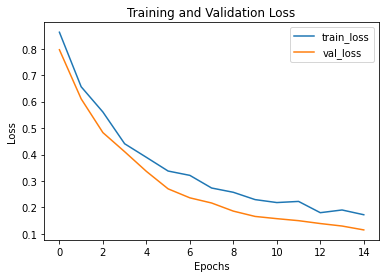

In [29]:
plt.plot(np.arange(0, epochs), hist.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), hist.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")

### Used pretrained model to detect faces in images and used opencv deep neural network module to read model and its config file.
### Weights of trained mask classifier model is loaded.

In [30]:
prototxtPath = './resources/face_detector/deploy.prototxt'
weightsPath = './resources/face_detector/res10_300x300_ssd_iter_140000.caffemodel'
face_model = cv2.dnn.readNet(prototxtPath, weightsPath)
model = load_model("./resources/model")

### Preprocess the images using Blob module of opencv which resizes and crops image from center, subtract mean values, scales values by scalefactor, swap Blue and Red channels and them pass the blob throught our network to obtain the face which are detected by the model.

#### Download a random image (named "test.png"), and test the model against this image

In [32]:
image = cv2.imread('./resources/test.png')
height, width = image.shape[:2]
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))
face_model.setInput(blob)
detections = face_model.forward()	 # To detect faces

### In this part we have loop through all the detections and if their score is greater than certain threshold then we have find the dimensions of face and use preprocessing steps used for training images. Then we have used model trained to predict the class of the face image by passing the image through it.


### Then Opencv functions are used to create bounding boxes, put text and save the image ("test_img_result.png"). 
### We can check the image after it has been saved. The result will be in the same directory as this file

In [33]:

threshold = 0.2
person_with_mask = 0;
person_without_mask = 0;
for i in range(0, detections.shape[2]):
	score = detections[0, 0, i, 2]
	if score > threshold:
		#coordinates of the bounding box
		box = detections[0, 0, i, 3:7] * np.array([width, height, width, height])
		X_start, Y_start, X_end, Y_end = box.astype("int")
		X_start, Y_start = (max(0, X_start), max(0, Y_start))
		X_end, Y_end = (min(width - 1, X_end), min(height - 1, Y_end))

		face = image[Y_start:Y_end, X_start:X_end]
		face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)		#Convert to rgb
		face = cv2.resize(face, (224, 224))					#resize
		face = img_to_array(face)							
		face = preprocess_input(face)
		face = np.expand_dims(face, axis=0)	
	
		mask, withoutMask = model.predict(face)[0]			#To predict mask or not on the face

		if mask > withoutMask:								#determining the label
			label = "Mask"
			person_with_mask += 1
		else: 
			label = "No Mask"
			person_without_mask += 1
			
		if label == "Mask":									#determine the color
			color = (0, 255, 0)
		else:
			color = (0, 0, 255)
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)		#label and probability
		cv2.putText(image, label, (X_start, Y_start - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(image, (X_start, Y_start), (X_end, Y_end), color, 2)
  
print("Number of person with mask : {}".format(person_with_mask))
print("Number of person without mask : {}".format(person_without_mask))
cv2.imwrite("test_img_result.png", image)

Number of person with mask : 5
Number of person without mask : 1


True